# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

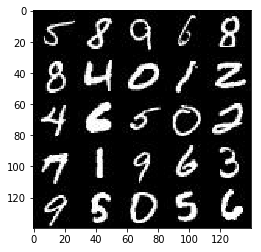

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

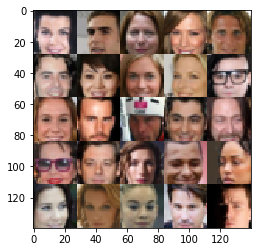

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(dtype=tf.float32, 
                                      shape=[None, image_width, image_height, image_channels],
                                      name="input_real")
  
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    def leaky_relu(x, alpha=0.1):
        return tf.maximum(alpha * x, x)
    
    keep_prob = 0.9
    
    with tf.variable_scope("discriminator", reuse=reuse):
#         print(images)

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = leaky_relu(conv1)
#         print(conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_relu(conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
#         print(conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_relu(conv3)
        conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob)
        
#         print(conv3)
        
        flat = tf.reshape(conv3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    def leaky_relu(x, alpha=0.1):
        return tf.maximum(alpha * x, x)
    
    with tf.variable_scope("generator", reuse=not(is_train)):

        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
#         print(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
#         print(x2)
        
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)
    
    disc_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                labels=tf.ones_like(disc_model_real)))
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                labels=tf.ones_like(disc_model_fake)))
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    steps = 0
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    disc_loss, gen_loss = model_loss(input_real, input_z, out_channel_dim)
    
    disc_train_opt, gen_train_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(disc_train_opt, feed_dict={input_real: batch_images,
                                                        input_z: batch_z,
                                                        lr: learning_rate})
                _ = sess.run(gen_train_opt, feed_dict={input_real: batch_images,
                                                       input_z: batch_z,
                                                       lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_disc = disc_loss.eval({input_z: batch_z,
                                                      input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_disc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, 
                                          out_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7346... Generator Loss: 5.1826
Epoch 1/2... Discriminator Loss: 2.1535... Generator Loss: 0.1787
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.4192
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 0.6065... Generator Loss: 1.3141
Epoch 1/2... Discriminator Loss: 0.9033... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 2.1805... Generator Loss: 0.1667
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.4157
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.4400


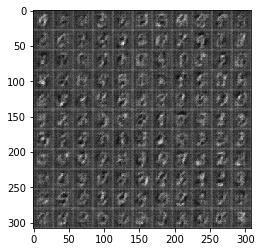

Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.5023
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 0.5481
Epoch 1/2... Discriminator Loss: 1.0892... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 0.7752... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 0.9205
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 0.8385
Epoch 1/2... Discriminator Loss: 0.6150... Generator Loss: 1.2896
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 0.5928... Generator Loss: 2.2313


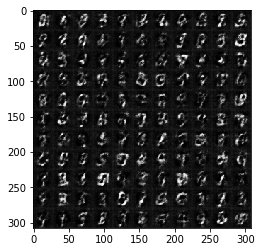

Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 1.5191
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 1.6421
Epoch 1/2... Discriminator Loss: 0.5531... Generator Loss: 1.8276
Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 1.8870
Epoch 1/2... Discriminator Loss: 0.4886... Generator Loss: 1.9223
Epoch 1/2... Discriminator Loss: 0.5901... Generator Loss: 1.2662
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 2.2798
Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 1.5536


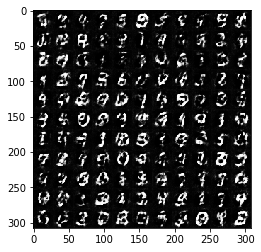

Epoch 1/2... Discriminator Loss: 0.5024... Generator Loss: 1.5375
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.4718
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 1.2451
Epoch 1/2... Discriminator Loss: 0.8209... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 2.2874
Epoch 1/2... Discriminator Loss: 0.4847... Generator Loss: 2.1043
Epoch 1/2... Discriminator Loss: 0.5429... Generator Loss: 1.9239
Epoch 1/2... Discriminator Loss: 0.5152... Generator Loss: 2.0630
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 3.0414
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 0.8544


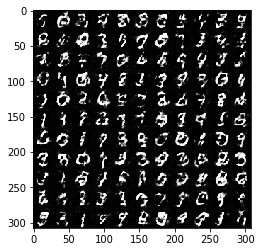

Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 0.6201... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 2.7432
Epoch 1/2... Discriminator Loss: 0.5950... Generator Loss: 1.4590
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.8551
Epoch 1/2... Discriminator Loss: 0.6338... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 2.1975
Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.6407
Epoch 2/2... Discriminator Loss: 1.5556... Generator Loss: 0.3016
Epoch 2/2... Discriminator Loss: 0.6690... Generator Loss: 1.5786


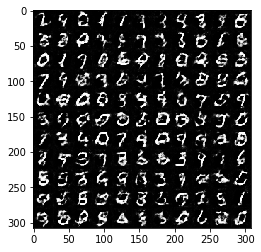

Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 2.4138
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 2.7239
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 2.1416
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.9472
Epoch 2/2... Discriminator Loss: 0.6661... Generator Loss: 1.9520
Epoch 2/2... Discriminator Loss: 0.6827... Generator Loss: 2.0605
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 2.0943
Epoch 2/2... Discriminator Loss: 0.8753... Generator Loss: 2.5783
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 2.4793
Epoch 2/2... Discriminator Loss: 0.7160... Generator Loss: 1.2899


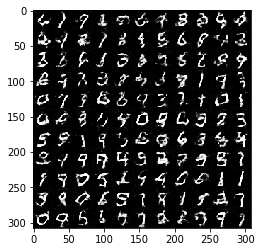

Epoch 2/2... Discriminator Loss: 0.8717... Generator Loss: 2.3989
Epoch 2/2... Discriminator Loss: 0.6423... Generator Loss: 1.9206
Epoch 2/2... Discriminator Loss: 0.7403... Generator Loss: 1.9455
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.6681... Generator Loss: 1.1423
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 0.7145... Generator Loss: 1.7961
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.8249


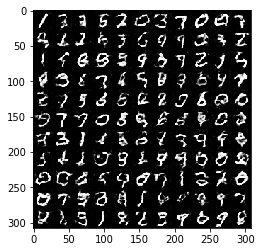

Epoch 2/2... Discriminator Loss: 0.7480... Generator Loss: 1.0047
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 0.6957... Generator Loss: 1.2967
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 2.7654
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 2.1855
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.3316
Epoch 2/2... Discriminator Loss: 0.7883... Generator Loss: 0.9718
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 2.6026
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.6468
Epoch 2/2... Discriminator Loss: 0.6865... Generator Loss: 1.4557


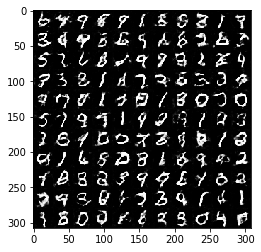

Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 0.9141... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.3736
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.0457... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.0402
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.4746


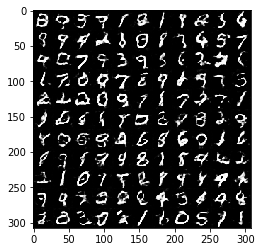

Epoch 2/2... Discriminator Loss: 0.6457... Generator Loss: 1.3696
Epoch 2/2... Discriminator Loss: 1.2211... Generator Loss: 0.5164
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 0.6347


In [15]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 0.4282... Generator Loss: 1.6505
Epoch 1/5... Discriminator Loss: 0.2179... Generator Loss: 2.5122
Epoch 1/5... Discriminator Loss: 0.4987... Generator Loss: 1.4729
Epoch 1/5... Discriminator Loss: 0.4785... Generator Loss: 1.3829
Epoch 1/5... Discriminator Loss: 1.6977... Generator Loss: 0.2759
Epoch 1/5... Discriminator Loss: 0.8287... Generator Loss: 1.7818
Epoch 1/5... Discriminator Loss: 0.8038... Generator Loss: 1.9444
Epoch 1/5... Discriminator Loss: 0.8248... Generator Loss: 1.9170
Epoch 1/5... Discriminator Loss: 0.6845... Generator Loss: 2.0564
Epoch 1/5... Discriminator Loss: 0.5466... Generator Loss: 1.9164


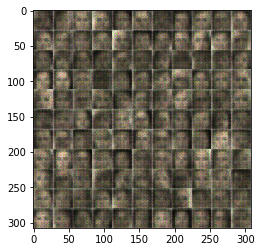

Epoch 1/5... Discriminator Loss: 0.9349... Generator Loss: 2.7764
Epoch 1/5... Discriminator Loss: 0.7475... Generator Loss: 3.1197
Epoch 1/5... Discriminator Loss: 0.9563... Generator Loss: 2.9096
Epoch 1/5... Discriminator Loss: 0.8051... Generator Loss: 2.7580
Epoch 1/5... Discriminator Loss: 0.8527... Generator Loss: 3.0036
Epoch 1/5... Discriminator Loss: 0.9174... Generator Loss: 1.8268
Epoch 1/5... Discriminator Loss: 0.9535... Generator Loss: 1.6859
Epoch 1/5... Discriminator Loss: 0.5487... Generator Loss: 2.1552
Epoch 1/5... Discriminator Loss: 0.6048... Generator Loss: 1.9256
Epoch 1/5... Discriminator Loss: 0.9607... Generator Loss: 2.4818


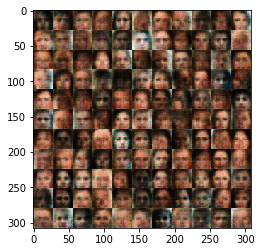

Epoch 1/5... Discriminator Loss: 1.4558... Generator Loss: 3.6805
Epoch 1/5... Discriminator Loss: 0.7331... Generator Loss: 0.9387
Epoch 1/5... Discriminator Loss: 0.5737... Generator Loss: 2.0705
Epoch 1/5... Discriminator Loss: 0.8982... Generator Loss: 2.7015
Epoch 1/5... Discriminator Loss: 0.6328... Generator Loss: 1.2305
Epoch 1/5... Discriminator Loss: 0.8384... Generator Loss: 2.0812
Epoch 1/5... Discriminator Loss: 1.0626... Generator Loss: 2.3171
Epoch 1/5... Discriminator Loss: 1.6803... Generator Loss: 0.2906
Epoch 1/5... Discriminator Loss: 0.9283... Generator Loss: 1.2682
Epoch 1/5... Discriminator Loss: 0.9480... Generator Loss: 1.9342


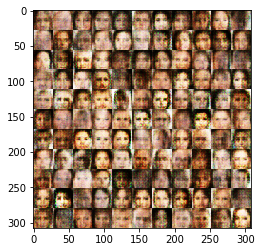

Epoch 1/5... Discriminator Loss: 1.2009... Generator Loss: 0.7143
Epoch 1/5... Discriminator Loss: 0.9487... Generator Loss: 0.7351
Epoch 1/5... Discriminator Loss: 0.7861... Generator Loss: 1.1814
Epoch 1/5... Discriminator Loss: 0.7403... Generator Loss: 1.9412
Epoch 1/5... Discriminator Loss: 0.8996... Generator Loss: 1.8984
Epoch 1/5... Discriminator Loss: 0.9295... Generator Loss: 0.8819
Epoch 1/5... Discriminator Loss: 1.2509... Generator Loss: 0.4926
Epoch 1/5... Discriminator Loss: 0.9763... Generator Loss: 0.7651
Epoch 1/5... Discriminator Loss: 2.4482... Generator Loss: 0.1266
Epoch 1/5... Discriminator Loss: 0.9570... Generator Loss: 1.0379


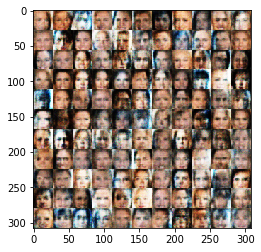

Epoch 1/5... Discriminator Loss: 1.3642... Generator Loss: 2.2149
Epoch 1/5... Discriminator Loss: 1.2861... Generator Loss: 1.7158
Epoch 1/5... Discriminator Loss: 1.1226... Generator Loss: 3.1114
Epoch 1/5... Discriminator Loss: 1.4887... Generator Loss: 0.3770
Epoch 1/5... Discriminator Loss: 1.0893... Generator Loss: 0.6788
Epoch 1/5... Discriminator Loss: 1.1203... Generator Loss: 0.6233
Epoch 1/5... Discriminator Loss: 1.1022... Generator Loss: 0.6665
Epoch 1/5... Discriminator Loss: 1.4389... Generator Loss: 0.4215
Epoch 1/5... Discriminator Loss: 1.0119... Generator Loss: 0.6633
Epoch 1/5... Discriminator Loss: 0.8285... Generator Loss: 1.0328


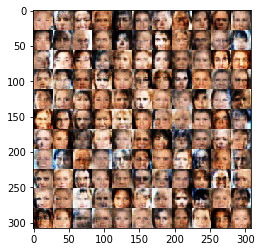

Epoch 1/5... Discriminator Loss: 0.8412... Generator Loss: 1.0173
Epoch 1/5... Discriminator Loss: 1.1196... Generator Loss: 1.5135
Epoch 1/5... Discriminator Loss: 1.0587... Generator Loss: 2.8495
Epoch 1/5... Discriminator Loss: 0.7564... Generator Loss: 2.7487
Epoch 1/5... Discriminator Loss: 0.7221... Generator Loss: 2.0831
Epoch 1/5... Discriminator Loss: 0.8561... Generator Loss: 2.1592
Epoch 1/5... Discriminator Loss: 0.8457... Generator Loss: 0.7525
Epoch 1/5... Discriminator Loss: 0.7057... Generator Loss: 0.9840
Epoch 1/5... Discriminator Loss: 1.3215... Generator Loss: 0.5805
Epoch 1/5... Discriminator Loss: 1.5069... Generator Loss: 0.3323


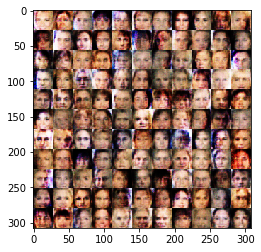

Epoch 1/5... Discriminator Loss: 1.0293... Generator Loss: 0.7328
Epoch 1/5... Discriminator Loss: 1.1063... Generator Loss: 0.5427
Epoch 1/5... Discriminator Loss: 1.4354... Generator Loss: 0.3599
Epoch 1/5... Discriminator Loss: 0.5119... Generator Loss: 2.4162
Epoch 1/5... Discriminator Loss: 0.8525... Generator Loss: 1.1271
Epoch 1/5... Discriminator Loss: 2.5546... Generator Loss: 0.1038
Epoch 1/5... Discriminator Loss: 0.7629... Generator Loss: 0.8741
Epoch 1/5... Discriminator Loss: 0.6802... Generator Loss: 1.8702
Epoch 1/5... Discriminator Loss: 0.6884... Generator Loss: 2.5443
Epoch 1/5... Discriminator Loss: 0.7294... Generator Loss: 1.4353


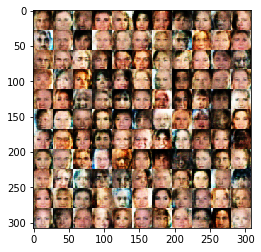

Epoch 1/5... Discriminator Loss: 1.2896... Generator Loss: 0.5007
Epoch 1/5... Discriminator Loss: 0.3450... Generator Loss: 2.1104
Epoch 1/5... Discriminator Loss: 1.1100... Generator Loss: 1.0320
Epoch 1/5... Discriminator Loss: 1.0611... Generator Loss: 1.8492
Epoch 1/5... Discriminator Loss: 0.5976... Generator Loss: 3.0175
Epoch 1/5... Discriminator Loss: 0.5166... Generator Loss: 2.5321
Epoch 1/5... Discriminator Loss: 0.8957... Generator Loss: 1.1871
Epoch 1/5... Discriminator Loss: 1.1713... Generator Loss: 0.5545
Epoch 1/5... Discriminator Loss: 0.8261... Generator Loss: 3.0887
Epoch 1/5... Discriminator Loss: 0.5427... Generator Loss: 2.2333


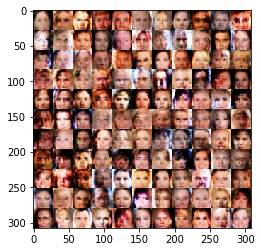

Epoch 1/5... Discriminator Loss: 0.9002... Generator Loss: 1.1491
Epoch 1/5... Discriminator Loss: 1.2737... Generator Loss: 2.8730
Epoch 1/5... Discriminator Loss: 0.4861... Generator Loss: 1.5169
Epoch 1/5... Discriminator Loss: 0.8200... Generator Loss: 0.7872
Epoch 1/5... Discriminator Loss: 1.1353... Generator Loss: 0.6411
Epoch 1/5... Discriminator Loss: 1.1067... Generator Loss: 0.6151
Epoch 1/5... Discriminator Loss: 1.6680... Generator Loss: 0.2787
Epoch 1/5... Discriminator Loss: 1.2614... Generator Loss: 0.3937
Epoch 1/5... Discriminator Loss: 0.4523... Generator Loss: 1.6206
Epoch 1/5... Discriminator Loss: 0.8916... Generator Loss: 2.5508


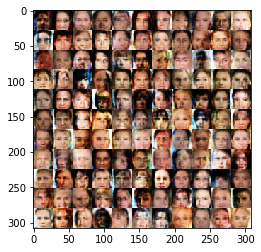

Epoch 1/5... Discriminator Loss: 0.4375... Generator Loss: 2.8133
Epoch 1/5... Discriminator Loss: 0.7451... Generator Loss: 0.9348
Epoch 1/5... Discriminator Loss: 1.6409... Generator Loss: 0.3085
Epoch 1/5... Discriminator Loss: 0.5454... Generator Loss: 1.4828
Epoch 1/5... Discriminator Loss: 0.3790... Generator Loss: 4.5067
Epoch 1/5... Discriminator Loss: 0.7162... Generator Loss: 1.5938
Epoch 1/5... Discriminator Loss: 0.3858... Generator Loss: 1.5630
Epoch 1/5... Discriminator Loss: 1.8105... Generator Loss: 0.2442
Epoch 1/5... Discriminator Loss: 0.3706... Generator Loss: 2.2240
Epoch 1/5... Discriminator Loss: 0.4086... Generator Loss: 4.3970


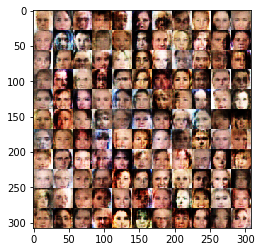

Epoch 1/5... Discriminator Loss: 0.8026... Generator Loss: 1.4677
Epoch 1/5... Discriminator Loss: 1.3118... Generator Loss: 0.4254
Epoch 1/5... Discriminator Loss: 1.2782... Generator Loss: 0.4621
Epoch 1/5... Discriminator Loss: 1.1025... Generator Loss: 2.3421
Epoch 1/5... Discriminator Loss: 1.1400... Generator Loss: 2.9119
Epoch 1/5... Discriminator Loss: 0.8887... Generator Loss: 2.3374
Epoch 1/5... Discriminator Loss: 0.5377... Generator Loss: 3.6492
Epoch 1/5... Discriminator Loss: 0.3294... Generator Loss: 5.7158
Epoch 1/5... Discriminator Loss: 1.3867... Generator Loss: 0.3550
Epoch 1/5... Discriminator Loss: 1.1328... Generator Loss: 0.5314


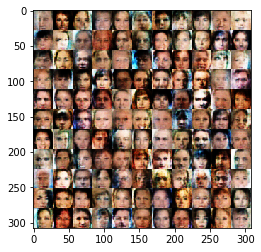

Epoch 1/5... Discriminator Loss: 0.9562... Generator Loss: 0.7055
Epoch 1/5... Discriminator Loss: 0.2991... Generator Loss: 3.9420
Epoch 1/5... Discriminator Loss: 0.6930... Generator Loss: 3.8785
Epoch 1/5... Discriminator Loss: 0.3768... Generator Loss: 1.4950
Epoch 1/5... Discriminator Loss: 0.3625... Generator Loss: 1.5194
Epoch 1/5... Discriminator Loss: 0.8145... Generator Loss: 2.2916
Epoch 1/5... Discriminator Loss: 0.2261... Generator Loss: 2.1449
Epoch 1/5... Discriminator Loss: 1.2727... Generator Loss: 0.4502
Epoch 1/5... Discriminator Loss: 0.2885... Generator Loss: 1.7624
Epoch 1/5... Discriminator Loss: 0.8273... Generator Loss: 0.7081


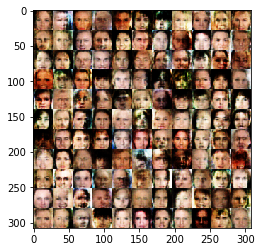

Epoch 1/5... Discriminator Loss: 1.0028... Generator Loss: 0.6355
Epoch 1/5... Discriminator Loss: 0.6985... Generator Loss: 0.9542
Epoch 1/5... Discriminator Loss: 0.8119... Generator Loss: 9.0430
Epoch 1/5... Discriminator Loss: 0.0754... Generator Loss: 4.7005
Epoch 1/5... Discriminator Loss: 0.1445... Generator Loss: 4.1732
Epoch 1/5... Discriminator Loss: 0.7352... Generator Loss: 0.9009
Epoch 1/5... Discriminator Loss: 0.1021... Generator Loss: 3.6932
Epoch 1/5... Discriminator Loss: 0.1572... Generator Loss: 4.5223
Epoch 1/5... Discriminator Loss: 0.5114... Generator Loss: 8.1361
Epoch 1/5... Discriminator Loss: 0.1357... Generator Loss: 2.6439


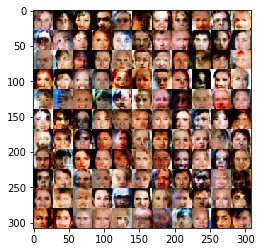

Epoch 1/5... Discriminator Loss: 0.2850... Generator Loss: 1.8790
Epoch 1/5... Discriminator Loss: 0.0388... Generator Loss: 4.4461
Epoch 1/5... Discriminator Loss: 0.0548... Generator Loss: 4.8167
Epoch 1/5... Discriminator Loss: 0.7833... Generator Loss: 0.8365
Epoch 1/5... Discriminator Loss: 0.6779... Generator Loss: 0.9936
Epoch 1/5... Discriminator Loss: 0.6531... Generator Loss: 1.0105
Epoch 1/5... Discriminator Loss: 0.2087... Generator Loss: 2.7006
Epoch 1/5... Discriminator Loss: 0.0723... Generator Loss: 4.7657
Epoch 1/5... Discriminator Loss: 0.1423... Generator Loss: 5.6873
Epoch 1/5... Discriminator Loss: 0.0797... Generator Loss: 4.3679


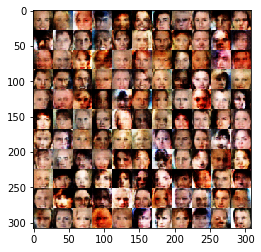

Epoch 1/5... Discriminator Loss: 0.2488... Generator Loss: 1.9954
Epoch 1/5... Discriminator Loss: 0.1144... Generator Loss: 3.1575
Epoch 1/5... Discriminator Loss: 0.1283... Generator Loss: 3.3147
Epoch 1/5... Discriminator Loss: 0.3140... Generator Loss: 6.2633
Epoch 1/5... Discriminator Loss: 0.0540... Generator Loss: 6.6385
Epoch 1/5... Discriminator Loss: 0.4785... Generator Loss: 7.1301
Epoch 1/5... Discriminator Loss: 0.0491... Generator Loss: 5.6378
Epoch 1/5... Discriminator Loss: 0.0430... Generator Loss: 5.5654
Epoch 1/5... Discriminator Loss: 1.8246... Generator Loss: 0.2573
Epoch 1/5... Discriminator Loss: 0.1750... Generator Loss: 3.1269


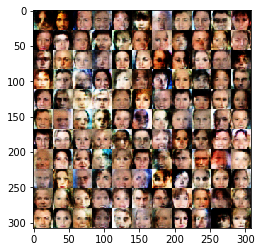

Epoch 1/5... Discriminator Loss: 0.1505... Generator Loss: 4.9488
Epoch 1/5... Discriminator Loss: 0.0863... Generator Loss: 4.5304
Epoch 1/5... Discriminator Loss: 0.4932... Generator Loss: 6.1909
Epoch 1/5... Discriminator Loss: 0.1838... Generator Loss: 2.3958
Epoch 1/5... Discriminator Loss: 0.2807... Generator Loss: 1.9109
Epoch 1/5... Discriminator Loss: 0.5882... Generator Loss: 7.0765
Epoch 1/5... Discriminator Loss: 0.5266... Generator Loss: 7.7975
Epoch 1/5... Discriminator Loss: 0.1094... Generator Loss: 2.6781
Epoch 2/5... Discriminator Loss: 1.0561... Generator Loss: 0.5588
Epoch 2/5... Discriminator Loss: 0.0590... Generator Loss: 3.6713


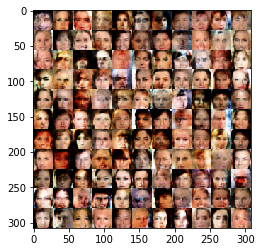

Epoch 2/5... Discriminator Loss: 0.0615... Generator Loss: 5.0325
Epoch 2/5... Discriminator Loss: 0.1292... Generator Loss: 5.5517
Epoch 2/5... Discriminator Loss: 0.0376... Generator Loss: 6.6326
Epoch 2/5... Discriminator Loss: 0.2496... Generator Loss: 1.9888
Epoch 2/5... Discriminator Loss: 2.1082... Generator Loss: 8.6859
Epoch 2/5... Discriminator Loss: 2.0714... Generator Loss: 0.1730
Epoch 2/5... Discriminator Loss: 0.9892... Generator Loss: 0.6155
Epoch 2/5... Discriminator Loss: 0.9527... Generator Loss: 0.7672
Epoch 2/5... Discriminator Loss: 0.3007... Generator Loss: 1.7436
Epoch 2/5... Discriminator Loss: 0.2606... Generator Loss: 1.9955


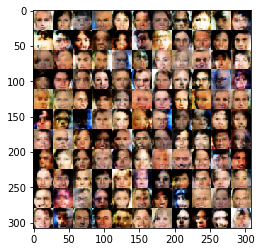

Epoch 2/5... Discriminator Loss: 0.5565... Generator Loss: 1.1492
Epoch 2/5... Discriminator Loss: 1.2883... Generator Loss: 0.3773
Epoch 2/5... Discriminator Loss: 0.1245... Generator Loss: 2.9174
Epoch 2/5... Discriminator Loss: 0.6305... Generator Loss: 1.0095
Epoch 2/5... Discriminator Loss: 0.6143... Generator Loss: 1.0643
Epoch 2/5... Discriminator Loss: 0.6233... Generator Loss: 0.9845
Epoch 2/5... Discriminator Loss: 0.2418... Generator Loss: 2.1324
Epoch 2/5... Discriminator Loss: 0.1693... Generator Loss: 7.1199
Epoch 2/5... Discriminator Loss: 0.1327... Generator Loss: 2.8190
Epoch 2/5... Discriminator Loss: 0.7021... Generator Loss: 8.0873


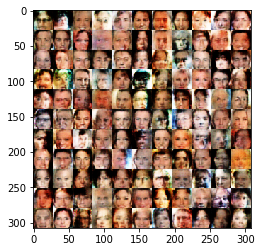

Epoch 2/5... Discriminator Loss: 0.1577... Generator Loss: 7.0305
Epoch 2/5... Discriminator Loss: 0.5101... Generator Loss: 6.8157
Epoch 2/5... Discriminator Loss: 0.2185... Generator Loss: 7.1977
Epoch 2/5... Discriminator Loss: 0.1415... Generator Loss: 2.8332
Epoch 2/5... Discriminator Loss: 0.3314... Generator Loss: 1.6082
Epoch 2/5... Discriminator Loss: 0.8025... Generator Loss: 7.0370
Epoch 2/5... Discriminator Loss: 0.1776... Generator Loss: 6.8260
Epoch 2/5... Discriminator Loss: 0.0785... Generator Loss: 3.3983
Epoch 2/5... Discriminator Loss: 1.4125... Generator Loss: 0.3526
Epoch 2/5... Discriminator Loss: 0.6008... Generator Loss: 1.0500


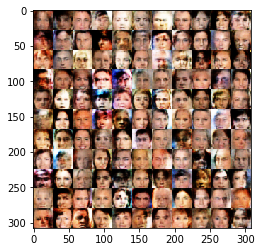

Epoch 2/5... Discriminator Loss: 0.4041... Generator Loss: 1.5070


KeyboardInterrupt: 

In [25]:
batch_size = 128
z_dim = 100
learning_rate = .0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.